In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
df_ACB = pd.read_csv('../data_vn_20230228/stock-historical-data/VCB-VNINDEX-History.csv')
df_series = df_ACB[-365:].reset_index()['Close']
df = df_series.to_frame()
df

,Close
0,75949.0
1,76104.0
2,75175.0
3,75949.0
4,75252.0
...,...
360,93000.0
361,93300.0
362,93500.0
363,92800.0


In [13]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [18]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 100000)


day 0: buy 1 units at price 75949.000000, total balance 24051.000000
day 11, sell 1 units at price 76801.000000, investment 1.121805 %, total balance 100852.000000,
day 21: buy 1 units at price 75097.000000, total balance 25755.000000
day 34, sell 1 units at price 75872.000000, investment 1.031999 %, total balance 101627.000000,
day 44: buy 1 units at price 76026.000000, total balance 25601.000000
day 52, sell 1 units at price 81136.000000, investment 6.721385 %, total balance 106737.000000,
day 60: buy 1 units at price 73859.000000, total balance 32878.000000
day 67, sell 1 units at price 77343.000000, investment 4.717096 %, total balance 110221.000000,
day 77: buy 1 units at price 79500.000000, total balance 30721.000000
day 86, sell 1 units at price 80000.000000, investment 0.628931 %, total balance 110721.000000,
day 100: buy 1 units at price 92000.000000, total balance 18721.000000
day 111, sell 1 units at price 86900.000000, investment -5.543478 %, total balance 105621.000000,
da

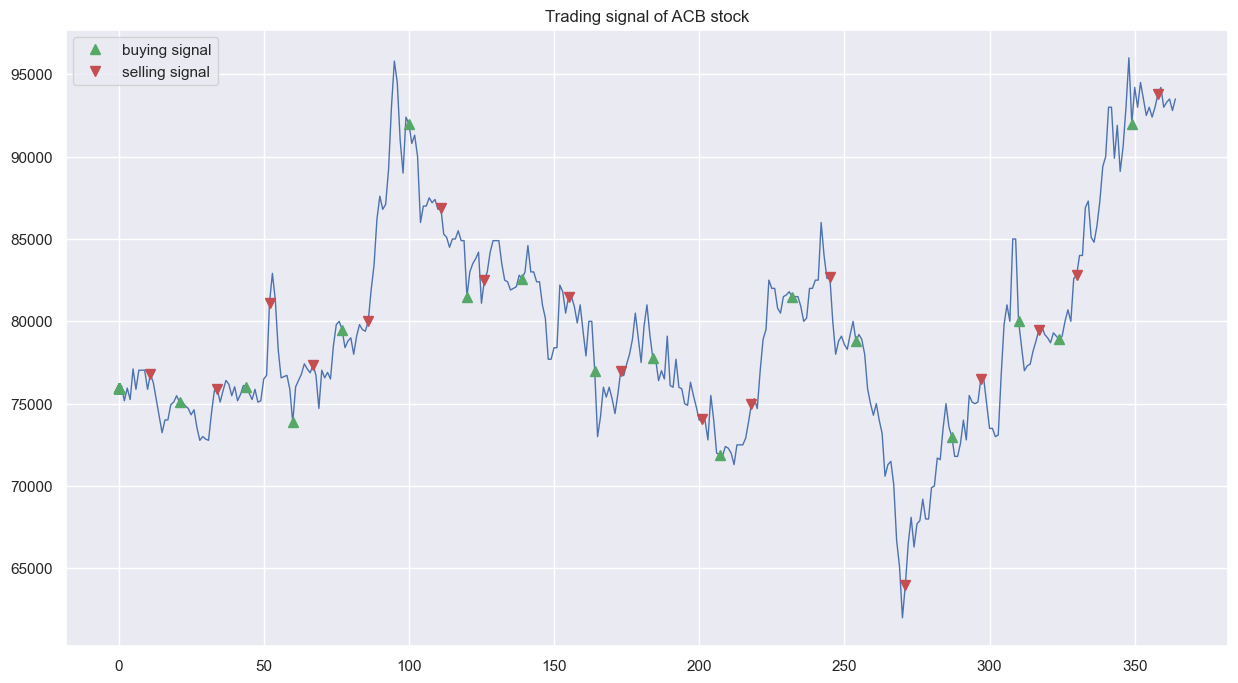

In [21]:
close = df['Close']
fig = plt.figure(figsize = (15,8))
plt.plot(close, color='b', lw=1)
plt.plot(close, '^', markersize=7, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=7, color='r', label = 'selling signal', markevery = states_sell)
# plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.title('Trading signal of ACB stock')
plt.legend()
plt.savefig('Trading Point.png')
plt.show()